# Unsupervised Face Clustering

    Table of Contents:
        0) Initial Setup
        1) Set paths of Data & Models
        2) Load Encoder
        3) Unsupervised Clustering
        4) Visualization


    Cluster Results:
        0 = glasses
        3 = low resolution
        5 = masks
        6 = males
        7 = babies
        8 = women
        9 = women with lipstick

## 0) Initial Setup

We start with loading the required packages.

In [1]:
# !pip install tensorflow
import numpy as np
import pandas as pd
import json
import os
from tqdm import tqdm

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import cluster

from PIL import Image, ImageFilter,ImageEnhance

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19


import tensorflow_datasets as tfds
from tensorflow.keras.utils import image_dataset_from_directory

import cv2
from google.colab.patches import cv2_imshow

## 1) Set paths to data & models

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# load data
base = '.'
LOADPATH = base + '/data/'
SAVEPATH = base + '/models/'

# Converting labels to np array
cat = [ 'skin_tone','age','gender']
lbs = [LabelBinarizer() for i in range(len(cat))]
length = width = 224

In [ ]:
# load labels data
TESTPATH = base + '/data/test/'
df_test = pd.read_csv(base+'/test_labels.csv')

# Convert labels to np array
print("Converting test labels to np array")
testY = []
for i in range(len(cat)):
    lab = lbs[i].fit_transform(df_test[cat[i]])
    if lab.shape[1]==1:
        testY.append(np.hstack((1-lab,lab)))
    else:
        testY.append(lab)
        
# load and convert images into np array
print("Loading test images")
nt = df_test.shape[0]
all_imgs = [image.load_img(TESTPATH+df_test.iloc[i]['name'], target_size=(length,width)) for i in range(nt)]

print("Converting test images to np array")
testX = np.empty([nt, length, width, 3], dtype=float)
for i in range(nt):
    testX[i,:] = image.img_to_array(all_imgs[i])
testX = K.applications.vgg19.preprocess_input(testX)

Converting test labels to np array
Loading test images
Converting test images to np array


## 2) Load Encoder

In [ ]:
# function to initialize a VGG19
def prepModel():
    v19_model = VGG19(include_top=False, weights='imagenet', input_tensor=K.Input(shape=[length,width,3]))

    for layer in v19_model.layers:
        layer.trainable = False
    model = K.models.Sequential()
    model.add(v19_model)
    model.add(K.layers.Flatten())
    return model

prep_model = prepModel()

## 3) Unsupervised clustering

In [ ]:
# Encode Data
X = prep_model.predict(X)

266/266 [==============================] - 296s 1s/step


In [ ]:
X.shape

(8488, 25088)

In [ ]:
spectral = cluster.SpectralClustering(
        n_clusters=10,
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    ).fit(X)

In [ ]:
df_test['cluster'] = spectral.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
pd.crosstab(df_test.gender, df_test.cluster)

cluster,0,1,2,3,4,5,6,7,8,9
gender,,,,,,,,,,
female,36,723,216,38,2,11,13,21,347,91
male,45,369,340,70,0,4,101,49,24,2


In [ ]:
pd.crosstab(df_test.skin_tone, df_test.cluster)

cluster,0,1,2,3,4,5,6,7,8,9
skin_tone,,,,,,,,,,
monk_1,5,59,18,4,0,0,8,16,29,6
monk_10,1,17,13,2,0,0,8,0,0,0
monk_2,10,126,75,17,0,1,19,17,68,21
monk_3,12,215,88,16,0,3,13,13,88,20
monk_4,15,198,92,18,1,3,13,9,95,23
monk_5,15,178,75,20,1,4,15,8,45,15
monk_6,8,107,51,15,0,2,8,2,26,4
monk_7,9,97,58,11,0,0,12,3,13,2
monk_8,4,49,53,5,0,0,11,1,6,2


In [ ]:
pd.crosstab(df_test.age, df_test.cluster)

cluster,0,1,2,3,4,5,6,7,8,9
age,,,,,,,,,,
0_17,3,242,105,13,1,3,30,70,69,7
18_30,45,566,189,36,1,7,47,0,244,79
31_60,31,256,214,49,0,5,34,0,56,7
61_100,2,28,48,10,0,0,3,0,2,0


In [ ]:
# save results
df_labeled[['name','skin_tone', 'gender', 'age', 'cluster']].to_csv('/content/gdrive/MyDrive/Richard/Stressed/BiasBounty/clusters.csv')

## 4) Visualize Results

In [8]:
def build_montages(image_list, image_shape, montage_shape):
    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

In [13]:
def samp_cluster(group, clusters):
  samp = clusters[(clusters.cluster == group)].sample(25)

  image_list = []
  for i,r in samp.iterrows():
    fp = '/content/gdrive/MyDrive/Richard/Stressed/BiasBounty/data/' + r['name']
    im = image.load_img(fp)
    image_list.append(image.img_to_array(im))
    
  # create a montage using 96x96 "tiles" with 5 rows and 5 columns
  montage = build_montages(image_list, (96, 96), (5, 5))[0]
  cv2_imshow(montage)
  cv2.waitKey(0)

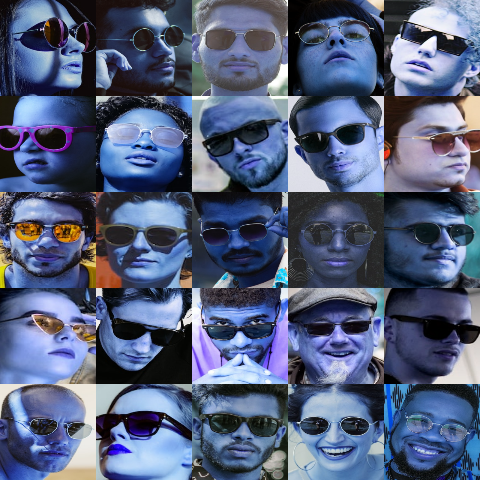

In [14]:
samp_cluster(0, clusters)

Cluster 0 is clearly faces with glasses

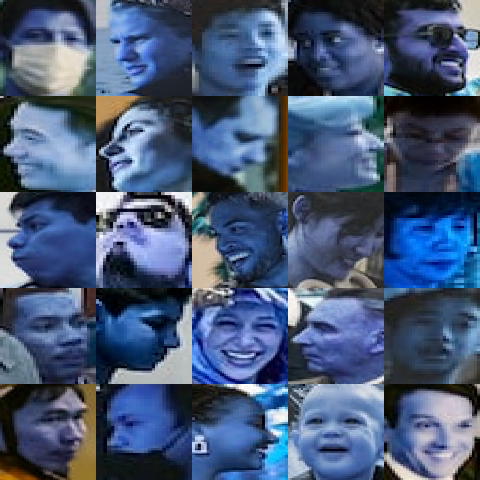

In [20]:
samp_cluster(3, clusters)

Cluster 3 are faces that had lower resolution

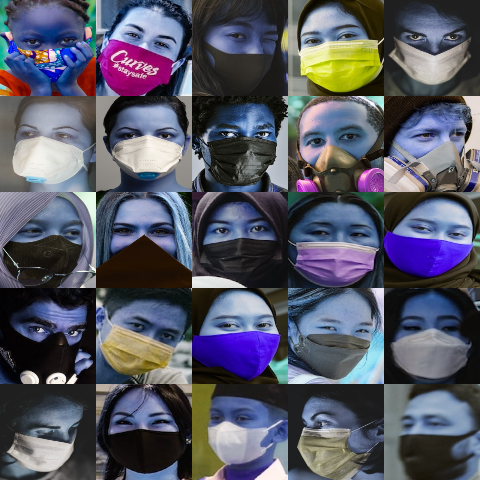

In [23]:
samp_cluster(5, clusters)

Cluster 5 are faces with masks

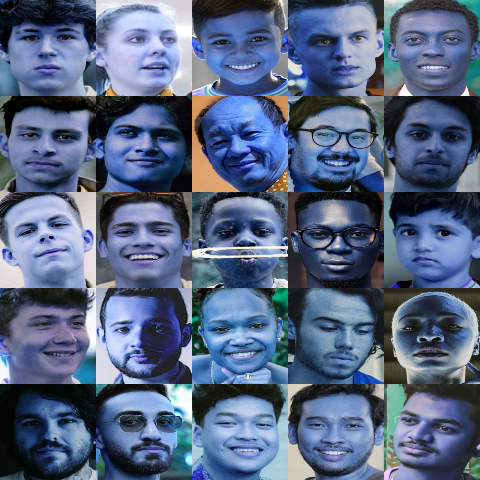

In [24]:
samp_cluster(6, clusters)

Cluster 6 is mostly male

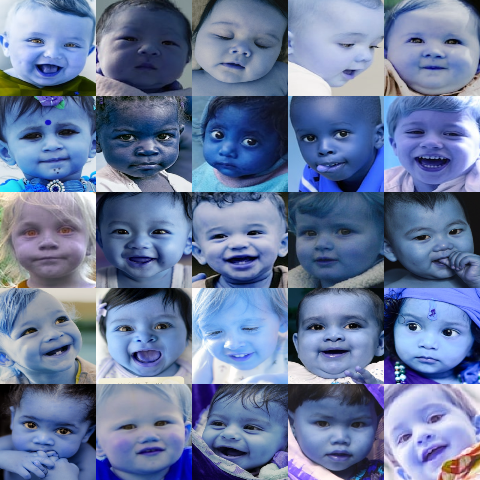

In [25]:
samp_cluster(7, clusters)

cluster 7 is babies

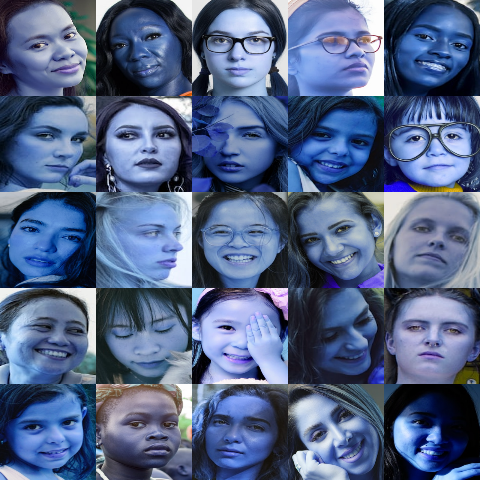

In [26]:
samp_cluster(8, clusters)

Cluster 8 is mostly women

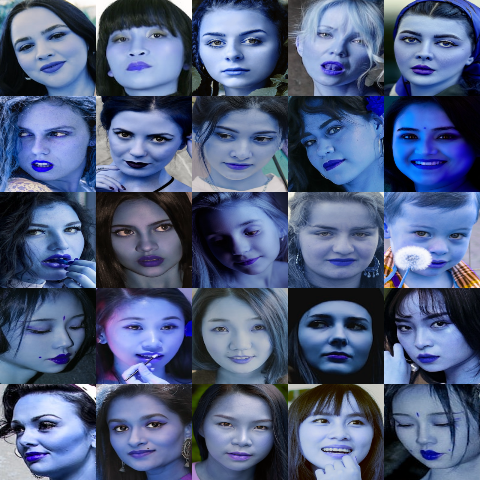

In [27]:
samp_cluster(9, clusters)

Lastly cluster 9 is women with bold lipstick